<h2><font color='#306998'><center>451 Financial Engineering: Programming Assignment 1</center></font></h2>
<h3><center>Genki Hirayama 07/12/2025 </center></h3>
---

## Overview 
We use machine learning classifiers, including tree-based ensemble boosting methods, to predict the direction of [Bitcoin (BTC)](https://en.wikipedia.org/wiki/Bitcoin) price movements (up or down) using a variety of lagged price features. In particular, we analyze daily closing spot prices for Bitcoin (BTC), incorporating lags of one to seven days, along with engineered features derived from daily open, high, low, and close (OHLC) prices, and trading volume.

This directional return prediction model lays the groundwork for evaluating the predictive power of additional signals. The space of potential features is broad, ranging from alternative asset price relationships and macroeconomic indicators to blockchain analytics, network activity, social sentiment, and news/media coverage.

### Import Libraries
We draw on Python packages for data manipulation and modeling. Most important are Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms.

In [11]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# import yfinance as yf  # used earlier to obtain the price series
# import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

### Retrieve Data
In previous work, we retrieved price data for btc from Yahoo Finance. The code is shown in the next commented-out cell.

In [31]:
'''
Previous work to retrieve data from Yahoo Finance

symbol = 'btc'
start_date = '2000-01-01'
end_date = '2025-05-27'

symbol = 'btc'
ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date, period = '1mo')
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_parquet("btc_historical_data.parquet", index=False)

'''

'\nPrevious work to retrieve data from Yahoo Finance\n\nsymbol = \'btc\'\nstart_date = \'2000-01-01\'\nend_date = \'2025-05-27\'\n\nsymbol = \'btc\'\nticker = yf.Ticker(symbol)\nhistorical_data = ticker.history(start = start_date, end = end_date, period = \'1mo\')\nprint(historical_data)\n\nprint("type of historical_data", type(historical_data))\n\nhistorical_data.to_parquet("btc_historical_data.parquet", index=False)\n\n'

### Polars DataFrame Development
The following code cell demonstrates Polars use with the time series DataFrame for our selected market/ticker, btc.

In [13]:
import pandas as pd
btc = pl.read_parquet("C:\\Users\\Genki\\Documents\\Homework\\Financial Machine Learning\\HW1\\Financial-Engineering-Assignment-1\\btc_historical_data.parquet")

#btc = pd.read_csv("C:/Users/Genki/Documents/Homework/Financial Machine Learning/HW1/btc_historical_data.csv")
#btc = pl.read_parquet("my_data_frame.parquet")
# check the original schema
print(btc.schema)

# create lag price features
btc = btc.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
btc = btc.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
btc = btc.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
btc = btc.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
btc = btc.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
btc = btc.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
btc = btc.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
btc = btc.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
btc = btc.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
btc = btc.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
btc = btc.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
btc = btc.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
btc = btc.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
btc = btc.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
btc = btc.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
btc = btc.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
btc = btc.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),    
    pl.col('Low').round(3),
    pl.col('Close').round(3),      
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),  
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),  
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),  
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),  
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),  
    pl.col('OMCLag3').round(3), 
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3), 
    pl.col('CloseEMA8').round(3))
    
# define binary target/response 1 = market price up since previous day, 0 = even or down 
btc = btc.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

print(btc.schema)

# save to external comma-delimited text file for checking calculations in Excel
btc.write_csv("C:/Users/Genki/Documents/Homework/Financial Machine Learning/HW1/btc-with-computed-features.csv")

Schema([('Date', Date), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Float64), ('Adjusted', Float64)])
Schema([('Date', Date), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Float64), ('Adjusted', Float64), ('CloseLag1', Float64), ('CloseLag2', Float64), ('CloseLag3', Float64), ('HML', Float64), ('HMLLag1', Float64), ('HMLLag2', Float64), ('HMLLag3', Float64), ('OMC', Float64), ('OMCLag1', Float64), ('OMCLag2', Float64), ('OMCLag3', Float64), ('VolumeLag1', Float64), ('VolumeLag2', Float64), ('VolumeLag3', Float64), ('CloseEMA2', Float64), ('CloseEMA4', Float64), ('CloseEMA8', Float64), ('LogReturn', Float64), ('Target', Int32)])


### Descriptive Statistics for Price Features

The dataset comprises 3,903 daily observations of Bitcoin (BTC), capturing a wide range of price and volume dynamics. The average closing price over the observed period is approximately $22,396, with substantial volatility evident in its range, from as low as $178 to a peak of $111,673. Other core price metrics such as the open, high, and low follow similar distributions. The adjusted close is identical to the closing price, indicating no dividend or split adjustments were applied. Daily trading volume shows significant dispersion, with an average around $19.5 billion and spikes reaching over $350 billion, reflecting BTC's evolving market activity over time.

The dataset also includes engineered features such as lagged prices, spreads, and exponential moving averages (EMAs). Lagged closing prices (1 to 3 days back) track closely with current prices, supporting the assumption of temporal dependence. The high-minus-low (HML) spread, averaging $1,001, and the open-minus-close (OMC) spread, averaging near zero but ranging from -$8,230 to +$8,182, illustrate both the typical and extreme intraday price movements. EMAs over 2-, 4-, and 8-day windows offer progressively smoother trends around the closing price. Log returns average around 0.14% daily with a standard deviation of 3.6%, indicating relatively modest directional drift amidst substantial noise. The binary target variable, which flags positive daily returns, is nearly balanced with 52.8% of the days classified as "up," making it well-suited for binary classification models.

In [32]:
# Drop the rows with null values such as the initial lag rows
btc = btc.drop_nulls()

# Descriptive statistics
btcStatistics = btc.drop('Date').describe()

print(btcStatistics.columns)

btcStatisticsToPrint = btcStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(btcStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(btcStatisticsToPrint)



['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema([('column', String), ('column_0', String), ('column_2', String), ('column_3', String), ('column_4', String), ('column_6', String), ('column_8', String)])
┌────────────┬──────────┬───────────────────────┬─────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2              ┆ column_3            ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════╪══════════╪═══════════════════════╪═════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                  ┆ std                 ┆ min                  ┆ 50%                   ┆ max   

### Feature List
Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of featrues includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.

In [15]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = btc.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC', 'Adjusted'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
394.796,424.44,457.334,43.303,43.756,15.752,29.307,32.42,8.53,3.79197e7,3.44832e7,2.10568e7,412.2,418.461,421.934
408.904,394.796,424.44,33.413,43.303,43.756,-14.231,29.307,32.42,3.68636e7,3.79197e7,3.44832e7,410.442,414.729,417.788
398.821,408.904,394.796,19.245,33.413,43.303,9.264,-14.231,29.307,2.65801e7,3.68636e7,3.79197e7,404.444,409.069,412.581
402.152,398.821,408.904,9.786,19.245,33.413,-3.052,9.264,-14.231,2.41276e7,2.65801e7,3.68636e7,403.28,406.754,410.014
435.791,402.152,398.821,45.36,9.786,19.245,-33.699,-3.052,9.264,4.50995e7,2.41276e7,2.65801e7,419.663,416.083,415.851


### Examine the Distribution of LogReturn Values

The average daily return is approximately 0.14%, indicating a slight upward bias over time. However, returns exhibit substantial volatility, with a standard deviation of 3.6%, and a wide range spanning from a minimum of -46.5% to a maximum of 22.5%. The distribution is right-skewed: the median return (0.13%) is slightly below the mean, and the interquartile range (from -1.26% to +1.66%) shows that the majority of daily movements are relatively small, with occasional big jumps.

In [16]:
# Define and examine the target for regression model development
print(btc['LogReturn'].describe())

y = np.array(btc['LogReturn'])


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 3903.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.00144   │
│ std        ┆ 0.036091  │
│ min        ┆ -0.46473  │
│ 25%        ┆ -0.012556 │
│ 50%        ┆ 0.001303  │
│ 75%        ┆ 0.016605  │
│ max        ┆ 0.225119  │
└────────────┴───────────┘


### Standardize All Features


In [17]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


### Target Definition for Classification (Target)



In [18]:
# Define and examine the target for classification model development
print(btc['Target'].value_counts())

y = np.array(btc['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 1      ┆ 2062  │
│ 0      ┆ 1841  │
└────────┴───────┘


### Feature Selection Using All Possible Classifications 
In order to refine our model selection process, we analyzed the ten models with the lowest AIC scores to identify which features were most consistently associated with strong predictive performance. For each of the top ten models, we extracted the feature combinations and counted the frequency of each feature’s appearance. This allowed us to quantify which features contributed most reliably to models with high explanatory power.

The five most frequently occurring features across these top models were: OMCLag1, HMLLag1, CloseLag3, CloseEMA2, and CloseEMA4. These selections highlight a consistent preference for lagged features capturing recent price movements (CloseLag3), volatility-based spread indicators (HMLLag1), and trend-following signals derived from exponential moving averages (CloseEMA2 and CloseEMA4). Most notably, OMCLag1, the one-day lag of the open-minus-close spread, appeared in nearly all top-performing models, underscoring its potential value as a directional predictor. This feature ranking informed the final subset used for subsequent model development and evaluation.

In [19]:
# Polars DataFrame for storing results from all possible subsets 
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64} 
resultsDataFrame = pl.DataFrame(schema = resultsSchema) 

def getAIC(X, y): 
    model = LogisticRegression()
    model.fit(X, y)
    # Calculate log-likelihood
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    # Calculate the number of parameters
    k = X.shape[1] + 1    
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik     
    # print(f"AIC: {aic}") # print for initial testing
    return aic

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
for c in powerset(range(X.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)          
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": "0 1 2 3 4 5 6 7 8 9 10 11 12 13 14",
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)          
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])


In [20]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬──────────┬─────────────┐
│ trialNumber ┆ features ┆ aic         │
│ ---         ┆ ---      ┆ ---         │
│ i64         ┆ str      ┆ f64         │
╞═════════════╪══════════╪═════════════╡
│ 46          ┆ 2 6      ┆ 5389.907334 │
│ 90          ┆ 6 12     ┆ 5389.923056 │
│ 91          ┆ 6 13     ┆ 5389.931781 │
│ 21          ┆ 0 6      ┆ 5389.93233  │
│ 34          ┆ 1 6      ┆ 5389.933659 │
│ 92          ┆ 6 14     ┆ 5389.93824  │
│ 292         ┆ 2 3 6    ┆ 5390.33114  │
│ 382         ┆ 3 6 14   ┆ 5390.363525 │
│ 381         ┆ 3 6 13   ┆ 5390.372338 │
│ 380         ┆ 3 6 12   ┆ 5390.378342 │
└─────────────┴──────────┴─────────────┘


In [21]:
import polars as pl
from collections import Counter
import numpy as np

# Assume X is already scaled with: X = scaler.fit_transform(np.array(X))
# Also assume featureNames exists as a list of original feature names

# Step 1: Get the top 10 combinations from resultsDataFrame
top_10 = resultsDataFrame.sort("aic").head(10)

# Step 2: Count feature index occurrences
all_features = []
for row in top_10.iter_rows(named=True):
    feature_indices = list(map(int, row['features'].split()))
    all_features.extend(feature_indices)

# Step 3: Get top 5 most common feature indices
feature_counts = Counter(all_features)
top5_indices = [idx for idx, _ in feature_counts.most_common(5)]

# Step 4: Map feature indices back to names using featureNames
best_features = [featureNames[i] for i in top5_indices]

print("Top 5 most frequent features from top 10 models:", best_features)


Top 5 most frequent features from top 10 models: ['OMCLag1', 'HMLLag1', 'CloseLag3', 'CloseEMA2', 'CloseEMA4']


### Selected Feature Subset
Reviewing the ten lowest *AIC* models, we selected five features for subsequent model development:

- **OMCLag1**: Lag-one open minus close daily prices  
- **HMLLag1**: Lag-one high minus low daily prices  
- **CloseLag3**: Lag-three daily closing price  
- **CloseEMA2**: Exponential moving average across two days  
- **CloseEMA4**: Exponential moving average across four days

In [22]:
# select subset of five columns as features
X = btc.select(best_features)


### Define Cross-Validation Training and Test Sets
Recognizing that time series observations are not independent observations, we use Scikit-Learn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for cross-validation. 

This cross-validation object is a variation of multi-fold cross-validation for independent observations. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Unlike cross-validation for independent observations, however, successive training sets are supersets of those that come before them. A listing of observation index numbers shows what this means for the time series market data in this demonstration.


In [23]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 643 with indices from  0 to 642
test_0 has 650 with indices from  653 to 1302

train_1 has 1293 with indices from  0 to 1292
test_1 has 650 with indices from  1303 to 1952

train_2 has 1943 with indices from  0 to 1942
test_2 has 650 with indices from  1953 to 2602

train_3 has 2593 with indices from  0 to 2592
test_3 has 650 with indices from  2603 to 3252

train_4 has 3243 with indices from  0 to 3242
test_4 has 650 with indices from  3253 to 3902


### Define an Initial Classification Model to Be Evaluated¶
We again select gradient boosting from the XGBoost package, this time defining a classification model to be evaluated. Hyperparameters are retained at defauld settings, except for n_estimators.

In [24]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Evaluate a Classification Model Within the Time Series Cross-Validation Design
Prior to executing a full-blown search for the "best" classification model, we test the cross-validation design on a binary classification model, revising code provided in online documentation for Scikit-Learn: [Time-related feature engineerng](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py). In particular, we define appropriate metrics for assessing classification performance.

In [25]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")



Mean model.n_estimators = 1000.0


(0.4932307692307692, 0.032235817486052414)

In [26]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.493 +/- 0.032



### Randomized Search for Hyperparameter Settings
This script conducts hyperparameter optimization for an XGBoost classifier using RandomizedSearchCV to enhance its ability to predict the direction of Bitcoin price movements. The search randomly samples 100 combinations of hyperparameters, such as max_depth, min_child_weight, subsample, learning_rate, and n_estimators, within predefined ranges. To ensure temporal integrity in the model evaluation, TimeSeriesSplit with a gap of 10 is used, which prevents information leakage from future observations into the training process. The evaluation metric is classification accuracy, and parallel processing speeds up the search process.

The best-performing configuration found through this search consists of a learning rate of approximately 0.078, a maximum tree depth of 4, a minimum child weight of 8, 712 boosting rounds (estimators), and a subsample ratio of about 0.952. Using this parameter combination, the model achieved a best cross-validated accuracy score of approximately 51.97%. While only slightly better than random guessing, this suggests some marginal predictive signal exists in the engineered features, but it also points to the challenges of short-term BTC return direction forecasting and the potential need for additional informative variables.

In [27]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.07761938857689385, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 712, 'subsample': 0.9518179342873276}
Best score: 0.5196923076923077


### Evaluate the Model
We define define an XGBoost subset model with these hyperparameter values and evaluate on the full data set.

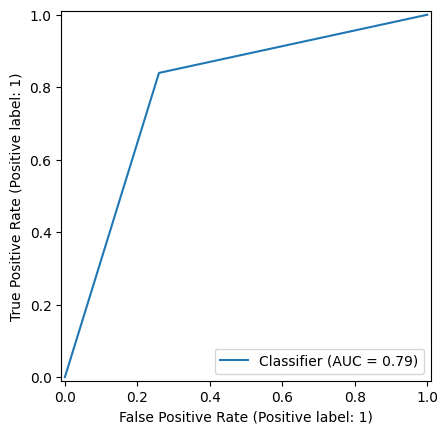

In [28]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 9, subsample = 0.50, learning_rate = 0.09, n_estimators = 273)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)
                    

Confusion Matrix
[[1363  478]
 [ 331 1731]]


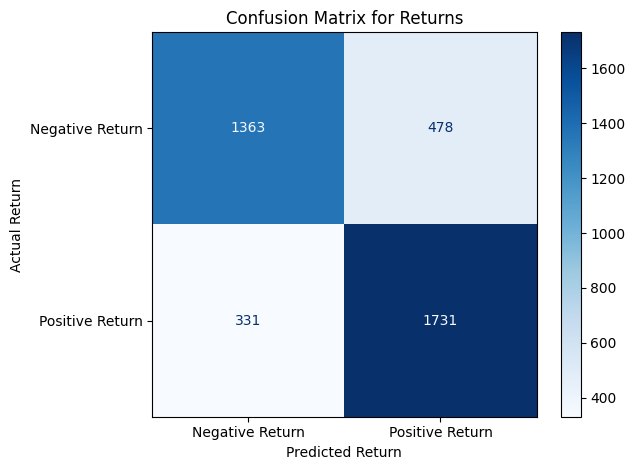

In [29]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()                              

In [30]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1841
           1       0.78      0.84      0.81      2062

   micro avg       0.79      0.79      0.79      3903
   macro avg       0.79      0.79      0.79      3903
weighted avg       0.79      0.79      0.79      3903



### Evaluation Summary

The evaluation results of the XGBoost classifier provide a strong indication that the model performs reasonably well in distinguishing between positive and negative Bitcoin returns. The confusion matrix shows that out of 3,903 total predictions, the model correctly predicted 1,731 positive returns and 1,363 negative returns. However, it also misclassified 478 negative returns as positive and 331 positive returns as negative, suggesting a slight bias toward predicting upward movements.

The ROC curve reveals an Area Under the Curve (AUC) of 0.79, which indicates good discriminatory power. A perfect classifier would score 1.0, while a value around 0.5 suggests no discriminative ability. Therefore, 0.79 reflects a fairly effective model in distinguishing between the two classes.

Looking at the classification report, the model achieved a precision of 0.80 for negative returns and 0.78 for positive returns, with recall values of 0.74 and 0.84, respectively. The overall f1-score for both classes hovered around 0.77 to 0.81, with macro, micro, and weighted averages all aligning at 0.79. These metrics confirm the model’s balanced performance, though with a slight tendency to be more confident and accurate in identifying upward trends. Further refinement may include exploring more features or adjusting the decision threshold to balance precision and recall.

## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).